# Lab1 KNN分类算法
- 姓名：彭钰钊
- 学号：2110756
- 专业：计算机科学与技术
- GitHub链接：https://github.com/Yuzhao-P/Machine-Learning
    > 上传历次实验数据文件和.ipynb文件，同时在README.md中更新有关实验的相关知识整理。
## 实验要求
题目：基于KNN 的手写数字识别  
实验条件：给定semeion手写数字数据集，给定kNN分类算法  
实验要求：

1. 基本要求：编程实现KNN算法；给出在不同k值（1，3，5）情况下，KNN算法对手写数字的识别精度（要求采用留一法）
2. 中级要求：与机器学习包中的KNN分类结果进行对比
3. 提高要求：采用旋转等手段对原始数据进行处理，扩增数据量，采用CNN或其他深度学习方法实现手写体识别

***截止日期：9月29日***

- 以学号+姓名(1)的命名形式打包实验代码+实验报告发送到邮箱18329300691@163.com
- 推荐使用.ipynb文件格式

### 导入所需要的包

In [1]:
# 导入本次实验所需要的包
import numpy as np
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier  # KNN分类器
from sklearn.model_selection import LeaveOneOut  # 留一法
from sklearn.metrics import accuracy_score  # 获取准确率
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # 划分数据集
import torch  # pytorch框架
import torch.nn as nn  # 深度学习模块
from torch.utils.data import TensorDataset, DataLoader  # 数据转换//批处理装载器


### 导入数据集semesion
采用独热编码，对应规则如下：  
[1 0 0 0 0 0 0 0 0 0] $\to$ 0  
[0 0 0 0 0 0 0 0 0 1] $\to$ 9

In [2]:
# 数据导入
def GetData(filepath):
    """
        按行读取文件并将其转换成矩阵(利用np),参数说明：
        str_All_lines : 按行读取的文件列表,每一行文本最为一个字符串存储在列表str_All_lines中
        col_num : 行数
        features_matrix : 特征矩阵
        labels_array : 类别标签数组
    """
    file = open(filepath)
    str_All_lines = file.readlines()
    col_num = len(str_All_lines)
    file.close()
    # 初始化特征矩阵和类别标签数组
    features_matrix = np.zeros((col_num,256))
    labels_array = np.zeros((col_num,1))
    # 根据数据给特征矩阵和类别标签数组赋值
    for i in range(col_num):
        # 将每一行数据分割开
        str_line = str_All_lines[i].split()
        for j in range(256):
            # 将 str 转换为 float 存入特征矩阵  注意!!!numpy现在删去了np.float的用法，因此使用np.float64
            features_matrix[i][j] = np.float64(str_line[j])
        label = 0
        # 将独热编码转换为标签值
        for j in range(256, 266):
            if str_line[j] != '1':
                label += 1
            else:
                break
        labels_array[i] = label
    return features_matrix, labels_array

In [3]:
# 获取数据并打印其维度
X, y = GetData('semeion.data')
np.shape(X), np.shape(y)

((1593, 256), (1593, 1))

## 基本要求
编程实现KNN算法；给出在不同k值（1，3，5）情况下，KNN算法对手写数字的识别精度（要求采用留一法）  
  
**留一法**  令K折交叉检验方法的K等于数据集大小，即只留**一个数据样本**作为测试集，其余都为训练集，计算平均准确率。
- 训练集：去除第i组数据后原始数据剩余部分
- 测试集：第i组数据
这里我将采用切片+`concatenate`函数的方式实现剔除第i组数据的目的，但是注意**切片是的区间是左闭右开！！！**  

【以此为例：`X_train = np.concatenate([X[:i], X[i:]], axis=0)` 
很蠢的错误，实际上并没有实现剔除第i组数据的效果，最终导致当k=1时其准确率为1，并且随着k的增加准确率降低】

In [4]:
# 采用留一法来切割数据集得到训练集和测试集
def loo_split(X, y, i):
    # 训练集：去除第i组数据剩余部分
    # 测试集：第i组数据
    X_train = np.concatenate([X[:i], X[i + 1:]], axis=0)
    X_test = X[i]

    y_train = np.concatenate([y[:i], y[i + 1:]], axis=0)
    y_test = y[i]
    return X_train, X_test, y_train, y_test

In [5]:
# 检查留一法结果
loo_split(X, y, 3)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,

KNN算法三要素之一是***距离***

因此我们需要定义一个距离函数，我们采用闵氏距离：假设两个n维变量 $A(x_{11},x_{12},\dots,x_{1n})$ 和 $B(x_{21},x_{22},\dots,x_{2n})$。  
对于这两个 n 维变量，则有闵氏距离公式为：$$d_{AB}=\sqrt[p]{\sum\limits_{k=1}^n{|x_{1k}-x_{2k}|^p}}$$
1. $p=1$时，闵氏距离即为曼哈顿距离：$$d_{AB}=\sum\limits_{k=1}^n{|x_{1k}-x_{2k}|}$$
2. $p=2$时，闵氏距离即为欧氏距离：$$d_{AB}=\sqrt{\sum\limits_{k=1}^n{(x_{1k}-x_{2k})^2}}$$
3. $p=\infty$时，闵氏距离即为切比雪夫距离：$$d_{AB}=\max{(|x_{k1}-x_{2k}|)}$$

In [6]:
# 寻找最近邻的K个点
def getKNeighbors(data_test, data_train, k, p):
    # 计算测试数据与训练数据之间的距离
    # 这里我们使用numpy中的范数计算方法np.linalg.norm
    # axis=1按行向量处理
    distances = np.linalg.norm((data_test-data_train), ord=p, axis=1)
    # 取最近邻的k个点的索引
    index = np.argsort(distances)[0:k]
    return index
        

In [7]:
class MyKNeighborsClassifier(object):
    """
        自定义的KNN分类器
    """


    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
    

    def fit(self, X, y):
        """
            惰性学习
        """
        self.X = X
        self.y = y 


    def predict(self, X_test):
        # 存放测试结果
        res = []
        # 默认采用欧氏距离
        index = getKNeighbors(X_test, self.X, self.n_neighbors, p=2)
        labels = self.y[index].flatten()
        # 把k近邻中最多的那个标签作为分类结果
        classifyRes = Counter(labels.tolist())
        classifyRes = classifyRes.most_common(1)[0][0]
        res.append(classifyRes)
        return np.array(res)

In [8]:
# KNN算法手动实现函数
def MyKnnClassifier(X, y, n_neighbors):
    # 预测正确个数
    acc = 0
    for i in range(y.shape[0]):
        # 留一法划分训练集和测试集
        X_train, X_test, y_train, y_test = loo_split(X, y, i)
        knn = MyKNeighborsClassifier(n_neighbors)
        knn.fit(X_train, y_train.ravel())
        y_pred = knn.predict(X_test)
        if y_pred == y_test:
            # 分类正确则将acc+1
            acc += 1
    accRate = acc / y.shape[0]
    print('k={0}时，测试个数为{1}  正确个数为：{2}  准确率为：{3}'.format(n_neighbors, y.shape[0], acc, accRate))
    return accRate

### 基本要求实验结果
我们最终选用的是$p=2$的欧氏距离，下面是基本要求的实验结果：

In [9]:
myAccRate1 = MyKnnClassifier(X, y, 1)
myAccRate3 = MyKnnClassifier(X, y, 3)
myAccRate5 = MyKnnClassifier(X, y, 5)

k=1时，测试个数为1593  正确个数为：1459  准确率为：0.9158819836785939
k=3时，测试个数为1593  正确个数为：1464  准确率为：0.9190207156308852
k=5时，测试个数为1593  正确个数为：1458  准确率为：0.9152542372881356


## 中级要求
与机器学习包中的KNN分类结果进行对比，我们选取Python的经典机器学习库scikit-learn中的`KNeighborsClassifier`分类器，来与我们的KNN的分类器进行对比。我们依然利用留一法划分数据集，这里使用scikit-learn中的`LeaveOneOut`。  

`get_n_splits(X, y=None, groups=None)`返回交叉验证器中的分裂迭代次数  
**Parameters**
- `X` array-like of shape (n_samples, n_features)  
训练数据，其中 n_samples 是样本数，n_​​features 是特征数。
- `y` object  
总是被忽略，存在是为了兼容性。
- `groups` object  
总是被忽略，存在是为了兼容性。  

**Returns**
- `n_splits` int  
返回交叉验证器中的拆分迭代次数。

`split(X, y=None, groups=None)`生成索引以将数据拆分为训练集和测试集。  
**Parameters**
- `X` array-like of shape (n_samples, n_features)  
训练数据，其中 n_samples 是样本数，n_​​features 是特征数。
- `y` array-like of shape (n_samples,)  
监督学习问题的目标变量。
- `groups` array-like of shape (n_samples,), default=None  
将数据集拆分为训练/测试集时使用的样本的分组标签。

**Yields**
- `trainndarray`  
该拆分的训练集索引。
- `testndarray`  
该拆分的测试集索引。

In [10]:
# KNN算法sklearn库实现
def skKnnClassifier(X, y, n_neighbors):
    knn = KNeighborsClassifier(n_neighbors)
    # 实例化LOO对象
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    mean_accuracy_score_list = []
    # 取LOO训练、测试集数据
    for train_idx, test_idx in loo.split(X):
        # train_idx 是指训练数据在总数据集上的索引位置
        # test_idx 是指测试数据在总数据集上的索引位置
        X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        knn.fit(X_train, y_train.ravel())
        y_pred = knn.predict(X_test)
        mean_accuracy_score_list.append(accuracy_score(y_test, y_pred))
    print('k={0}时，scikit-learn训练手写体识别的准确率为：{1}'.format(n_neighbors, np.average(mean_accuracy_score_list)))
    return np.average(mean_accuracy_score_list)

### 中级要求实验结果
首先让我们输出scikit-learn实现KNN算法的准确率

In [11]:
skAccRate1 = skKnnClassifier(X, y, 1)
skAccRate3 = skKnnClassifier(X, y, 3)
skAccRate5 = skKnnClassifier(X, y, 5)

k=1时，scikit-learn训练手写体识别的准确率为：0.9171374764595104
k=3时，scikit-learn训练手写体识别的准确率为：0.903954802259887
k=5时，scikit-learn训练手写体识别的准确率为：0.9052102950408035


接下来我们通过可视化的方式对比手动实现的KNN分类器和通过sklearn实现的KNN分类器

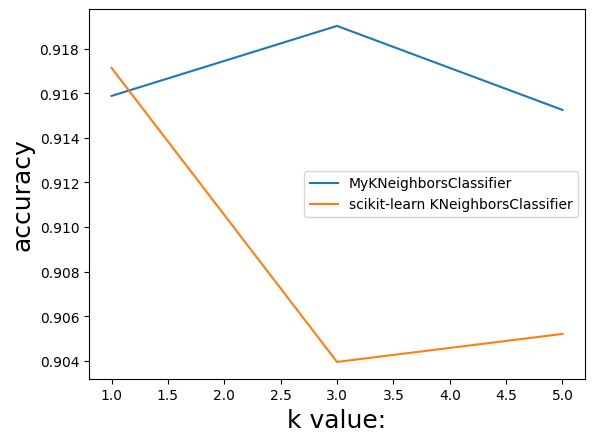

In [12]:
myKNNAccRates = [myAccRate1, myAccRate3, myAccRate5]
skKNNAccRates = [skAccRate1, skAccRate3, skAccRate5]
plt.xlabel('k value:',fontsize=18)
plt.ylabel('accuracy',fontsize=18)
plt.plot([1,3,5], myKNNAccRates, label='MyKNeighborsClassifier')
plt.plot([1,3,5], skKNNAccRates, label='scikit-learn KNeighborsClassifier')
plt.legend()
plt.show()

从现有的不同k值（1，3，5）情况下的数据上来对比我们手动实现的KNN算法和利用sklearn库实现的KNN算法可以发现，我们的KNN算法能够达到较高的准确率（90%以上），与sklearn中的KNN算法准确率水平相当。  
为了更好的与机器学习包中的KNN分类结果进行对比，我们在利用sklearn实现KNN算法时采用了控制变量法尽可能地减少了除分类器内部实现以外的干扰因素的影响。  
因为我们采用了**留一法**来进行交叉验证，因此一般情况下在k值相同时我们得出的准确率应该是相同的，那么为什么会出现上面对比的不同呢？猜测可能的原因：
- 算法的具体实现上存在细节上的差异，如边界处理等
- 随机性：如距离相同时的处理方案、样本选择等

经过对比sklearn库中实现KNN算法的[源码](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/neighbors/_classification.py)我发现最有可能的原因就是在距离相同时的处理方案不同，我们手动实现的KNN算法遇到距离相同的情况时会选择第一个标签，而sklearn中的KNN算法是随机选取的标签。（当然，以上仅仅是个人的一个猜测，尚不能很好的解释这个现象）  
接下来我们改变k值再次对比两个KNN算法

In [13]:
myKNNaccuracy = []
skKNNaccuracy = []
for k in range(1,31):
    myKNNacc = MyKnnClassifier(X, y, k)
    myKNNaccuracy.append(myKNNacc)
    skKNNacc = skKnnClassifier(X, y, k)
    skKNNaccuracy.append(skKNNacc)

k=1时，测试个数为1593  正确个数为：1459  准确率为：0.9158819836785939
k=1时，scikit-learn训练手写体识别的准确率为：0.9171374764595104
k=2时，测试个数为1593  正确个数为：1459  准确率为：0.9158819836785939
k=2时，scikit-learn训练手写体识别的准确率为：0.8801004394224733
k=3时，测试个数为1593  正确个数为：1464  准确率为：0.9190207156308852
k=3时，scikit-learn训练手写体识别的准确率为：0.903954802259887
k=4时，测试个数为1593  正确个数为：1465  准确率为：0.9196484620213434
k=4时，scikit-learn训练手写体识别的准确率为：0.9045825486503453
k=5时，测试个数为1593  正确个数为：1458  准确率为：0.9152542372881356
k=5时，scikit-learn训练手写体识别的准确率为：0.9052102950408035
k=6时，测试个数为1593  正确个数为：1464  准确率为：0.9190207156308852
k=6时，scikit-learn训练手写体识别的准确率为：0.9033270558694287
k=7时，测试个数为1593  正确个数为：1469  准确率为：0.9221594475831764
k=7时，scikit-learn训练手写体识别的准确率为：0.9096045197740112
k=8时，测试个数为1593  正确个数为：1472  准确率为：0.9240426867545511
k=8时，scikit-learn训练手写体识别的准确率为：0.9058380414312618
k=9时，测试个数为1593  正确个数为：1471  准确率为：0.9234149403640929
k=9时，scikit-learn训练手写体识别的准确率为：0.911487758945386
k=10时，测试个数为1593  正确个数为：1465  准确率为：0.9196484620213434
k=10时，scikit-learn训练手写体识别的准确率为：0.9045825

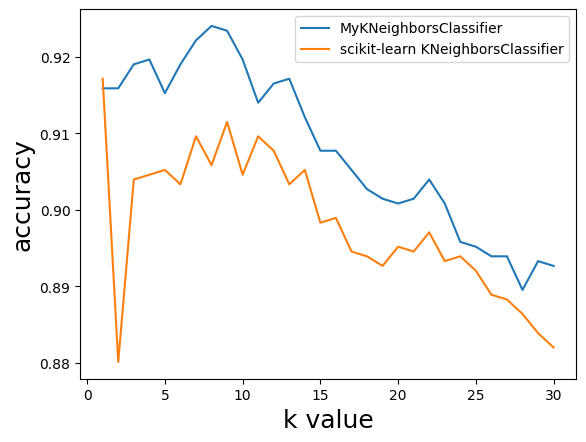

In [14]:
plt.xlabel('k value',fontsize=18)
plt.ylabel('accuracy',fontsize=18)
plt.plot(np.arange(1,31), myKNNaccuracy, label='MyKNeighborsClassifier')
plt.plot(np.arange(1,31), skKNNaccuracy, label='scikit-learn KNeighborsClassifier')
plt.legend()
plt.show()

根据我们的进一步对比分析，两种实现方式的整体趋势大致相同，当k值较小时，KNN模型的准确率较高，但是对于噪声更加敏感，容易使得模型过拟合；根据我们可视化数据可以发现，对于数据而言整体噪声较小，但是随着k值的增大，模型的决策边界变得更加平滑，无法捕捉到数据的细微特征，并且可能导致欠拟合，从而使得准确率降低。  
同时我们对比手动实现的KNN和通过sklearn库实现的KNN准确率可以发现，随着K值的继续增加，手动实现的KNN模型的准确率保持稳定，而scikit-learn的KNN模型的准确率略有下降。这可能是因为较大的K值导致模型更倾向于多数类别，从而降低了模型的敏感性，整体而言我们手动实现的KNN准确率相比会更高，说明我们实现的KNN模型性能还是值得肯定的。

## 提高要求
采用旋转等手段对原始数据进行处理，扩增数据量，采用CNN或其他深度学习方法实现手写体识别
### 采用旋转的手段对原始数据进行扩增处理
首先我们再次回过头来分析我们的数据集，在实验的课件中给出了数据的示意图，每一个手写体是由$16\times16$的二维特征值空间构成的，而我们的数据集将每一个手写体二维特征值空间平铺成一个一维的数组，即数据集的前256列，后10列则是由独热编码表示的数据类别。  
那么我们可以把一维数组重新恢复成二维数组，那么我们可以旋转二维数组对原始数据进行扩增，在这里我们采用将矩阵顺时针旋转90度和左右镜像的方式。

In [15]:
def DataRevolve(X, data_label_mapping):
    """
        顺时针旋转90°
    """
    data_list = []
    labels_list = []
    for i in range(0,X.shape[0]) :
        data = X[i].reshape(16, 16)[::-1].T
        data_list.append(data.flatten())
        # 获取对应的标签
        label = data_label_mapping[i]
        labels_list.append(label)
    data_list = np.array(data_list)
    labels_list = np.array(labels_list)
    return data_list, labels_list


def DataMirroring(X, data_label_mapping):
    """
        镜像（左右镜像）
    """
    data_list = []
    labels_list = []
    for i in range(0,X.shape[0]) :
        data = X[i].reshape(16, 16)[:,::-1]
        data_list.append(data.flatten())
    # 获取对应的标签
        label = data_label_mapping[i]
        labels_list.append(label)
    data_list = np.array(data_list)
    labels_list = np.array(labels_list)
    return data_list, labels_list

In [16]:
# 创建数据-标签映射——这是必要的！！！否则我们做的就不是数据扩增（数据增强），而是噪声增强了【切记切记】
data_label_mapping = {i: label for i, label in enumerate(y)}
X_R, y_R = DataRevolve(X, data_label_mapping)
X_M, y_M = DataRevolve(X, data_label_mapping)
X_new = np.concatenate([X, X_R, X_M], axis=0)
y_new = np.concatenate([y, y_R, y_M], axis=0)
np.shape(X_new), np.shape(y_new)

((4779, 256), (4779, 1))

In [17]:
myKNNaccuracy_new = []
skKNNaccuracy_new = []
for k in range(1,31):
    myKNNacc_new = MyKnnClassifier(X_new, y_new, k)
    myKNNaccuracy_new.append(myKNNacc_new)
    skKNNacc_new = skKnnClassifier(X_new, y_new, k)
    skKNNaccuracy_new.append(skKNNacc_new)

k=1时，测试个数为4779  正确个数为：4646  准确率为：0.9721699100230173
k=1时，scikit-learn训练手写体识别的准确率为：0.9717514124293786
k=2时，测试个数为4779  正确个数为：4646  准确率为：0.9721699100230173
k=2时，scikit-learn训练手写体识别的准确率为：0.9186022180372463
k=3时，测试个数为4779  正确个数为：4399  准确率为：0.9204854572086211
k=3时，scikit-learn训练手写体识别的准确率为：0.9152542372881356
k=4时，测试个数为4779  正确个数为：4492  准确率为：0.939945595312827
k=4时，scikit-learn训练手写体识别的准确率为：0.9177652228499686
k=5时，测试个数为4779  正确个数为：4481  准确率为：0.9376438585478134
k=5时，scikit-learn训练手写体识别的准确率为：0.9322033898305084
k=6时，测试个数为4779  正确个数为：4506  准确率为：0.9428750784682988
k=6时，scikit-learn训练手写体识别的准确率为：0.9206947060054405
k=7时，测试个数为4779  正确个数为：4433  准确率为：0.9275999163004812
k=7时，scikit-learn训练手写体识别的准确率为：0.9211132035990793
k=8时，测试个数为4779  正确个数为：4479  准确率为：0.9372253609541745
k=8时，scikit-learn训练手写体识别的准确率为：0.9148357396944967
k=9时，测试个数为4779  正确个数为：4444  准确率为：0.9299016530654949
k=9时，scikit-learn训练手写体识别的准确率为：0.9217409499895376
k=10时，测试个数为4779  正确个数为：4450  准确率为：0.9311571458464114
k=10时，scikit-learn训练手写体识别的准确率为：0.913789

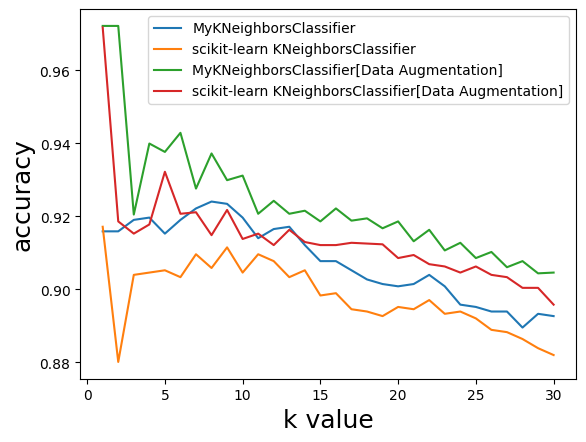

In [18]:
plt.xlabel('k value',fontsize=18)
plt.ylabel('accuracy',fontsize=18)
plt.plot(np.arange(1,31), myKNNaccuracy, label='MyKNeighborsClassifier')
plt.plot(np.arange(1,31), skKNNaccuracy, label='scikit-learn KNeighborsClassifier')
plt.plot(np.arange(1,31), myKNNaccuracy_new, label='MyKNeighborsClassifier[Data Augmentation]')
plt.plot(np.arange(1,31), skKNNaccuracy_new, label='scikit-learn KNeighborsClassifier[Data Augmentation]')
plt.legend()
plt.show()

从上面的可视化数据我们可以发现，数据扩增之后两种实现KNN的方式其准确率都有比较明显的提升，同时峰值大大提高（扩增数据：0.97；原始数据：0.91）。这是因为在一定程度上减小了噪声的影响，同时旋转数据扩增使得模型能够更好的捕捉实例不同的视角，从而提高了模型的准确率。看起来我们自己实现的KNN算法表现还是很好的，即使是数据扩增之后的sklearn实现的KNN算法也有部分准确率略逊于我们未进行数据扩增的手动KNN算法。  
值得注意的是，要**做好数据和标签的映射关系**，否则“数据扩增”就变成了“噪声扩增”，血和泪的经验（bushi）。

#### 采用CNN实现手写体识别
首先我们把ndarray的数据类型转换为torch的核心数据类型tensor（张量），利用`torch.from_numpy()`。
> `data.numpy()`：Tensor –> Numpy.ndarray

接下来我们准备开始实现CNN，先定义一些超参数

In [19]:
# 超参数设置
batch_size = 128  # 每次批量数
learning_rate = 0.005  # 学习率
num_epochs = 25  # 迭代次数
# 设置训练配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# 处理数据格式
X_CNN = X_new[:X_new.shape[0] // batch_size * batch_size, :].reshape(X_new.shape[0] // batch_size * batch_size, 1, 16, 16)
y_CNN = y_new[:y_new.shape[0] // batch_size * batch_size, :]
X_train, X_test, y_train, y_test = train_test_split(X_CNN, y_CNN, test_size=0.2, random_state=38)
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).float()
y_test_tensor = torch.from_numpy(y_test).float()

# 创建训练和测试数据集的 Dataset 对象
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 创建 DataLoader 装载数据集
Train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
Test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

In [21]:
# 搭建CNN架构
class CNN(nn.Module):
    def __init__(self, in_channel=1, feature=8, num_class=10):
        super(CNN, self).__init__()
        self.Layer1 = nn.Sequential(
            nn.Conv2d(in_channel, feature, kernel_size=3, stride=1, padding=1),  # 3,1,1 -- 保持图片维度不变 B*1*16*16 --> B*8*16*16
            nn.BatchNorm2d(feature),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 降维 B*8*16*16 --> B*8*8*8
        )
        self.Layer2 = nn.Sequential(
            nn.Conv2d(feature, feature*2, kernel_size=3, stride=1, padding=1),  # 3,1,1 -- 保持图片维度不变 B*8*8*8 --> B*16*8*8
            nn.BatchNorm2d(feature*2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 降维 B*16*8*8 --> B*16*4*4
        )
        self.Fc = nn.Linear(16*4*4, num_class)


    def forward(self, x):
        x = self.Layer1(x)
        x = self.Layer2(x)
        x = x.reshape(x.shape[0], -1)
        x = self.Fc(x)
        return x

In [22]:
# 初始化架构
model = CNN(in_channel=1, feature=8, num_class=10).to(device)

# 定义损失函数和优化器
LossFuc = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # 随机优化方法

# 训练
for epoch in range(num_epochs):
    for batch_index, (images, labels) in enumerate(Train_loader):
        images = images.to(device)
        labels = labels.to(device).flatten()

        outputs = model(images)

        loss = LossFuc(outputs, labels.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 0:
            print('epoch/num_epochs:[{}/{}],batch_index/batchs:[{}/{}],loss={:.4f}'.format(epoch,num_epochs,batch_index,len(Train_loader),loss))

# 测试
# 禁止参数迭代
with torch.no_grad():
    loss_num = 0
    correct_num = 0
    total_num = 0
    for images, labels in Test_loader:
        images = images.to(device)
        labels = labels.to(device).flatten()
        outputs = model(images)
        loss = LossFuc(outputs, labels.long())
        loss_num += loss.data.item()*labels.size(0)
        _, predictions = torch.max(outputs,1)
        correct_num = (predictions==labels).sum()
        total_num = (predictions.size(0))
        print("测试集的损失为：{:.6f} 精度为：{:.6f}".format(loss_num / total_num, correct_num / total_num))

epoch/num_epochs:[0/25],batch_index/batchs:[0/60],loss=2.5362
epoch/num_epochs:[0/25],batch_index/batchs:[10/60],loss=1.3479
epoch/num_epochs:[0/25],batch_index/batchs:[20/60],loss=0.9653
epoch/num_epochs:[0/25],batch_index/batchs:[30/60],loss=0.8646
epoch/num_epochs:[0/25],batch_index/batchs:[40/60],loss=0.7565
epoch/num_epochs:[0/25],batch_index/batchs:[50/60],loss=0.5894
epoch/num_epochs:[1/25],batch_index/batchs:[0/60],loss=0.5401
epoch/num_epochs:[1/25],batch_index/batchs:[10/60],loss=0.4166
epoch/num_epochs:[1/25],batch_index/batchs:[20/60],loss=0.2881
epoch/num_epochs:[1/25],batch_index/batchs:[30/60],loss=0.3340
epoch/num_epochs:[1/25],batch_index/batchs:[40/60],loss=0.3983
epoch/num_epochs:[1/25],batch_index/batchs:[50/60],loss=0.2618
epoch/num_epochs:[2/25],batch_index/batchs:[0/60],loss=0.3416
epoch/num_epochs:[2/25],batch_index/batchs:[10/60],loss=0.1377
epoch/num_epochs:[2/25],batch_index/batchs:[20/60],loss=0.2807
epoch/num_epochs:[2/25],batch_index/batchs:[30/60],loss=0.

通过实验结果我们可以发现，CNN的表现在绝大多数情况下优于KNN，但KNN的峰值可以与之持平。并且从训练的过程我们可以看见，随着训练的增加loss的变化趋势是减小的。事实上，CNN在图像分类任务中的表现通常优于KNN，因为它们能够自动学习特征、具有层次结构、参数共享等特性，以及在训练时通常采用数据增强等技术来提高模型的性能和泛化能力。这些因素使CNN成为处理图像数据的强大工具。而KNN更适用于一些简单的分类任务，对于高维数据和大规模数据集来说，计算成本较高，容易受到维度灾难的影响。

## 实验总结
与其说是实验总结不如说是一点点感想，通过这次实验去了解了KNN算法实现的逻辑，同时动手实现了该算法，虽然从准确率上看似乎比sklearn中的KNN更好，但是事实上在阅读了sklearn源码后会发现，我仅仅实现了功能，而未考虑一些异常情况，也没有设置更多的可选参数，整体的封装也做得不够好。  
在这次实验中感受到python或者说机器学习的编程与一般程序的不同，更多的是边写边调试，报错即改，同时体会到了python语法的兼容和模糊性，还有很多值得学习总结的地方。